# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 28 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 28 ноября, -4 балла после 06:00 5 декабря, -6 баллов после 06:00 12 декабря, -8 баллов после 19 декабря

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import preprocessing
from time import time
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

#%load_ext pycodestyle_magic

In [85]:
#%%pycodestyle


class MyKmeans: 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random',
                batch_size=None):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        self.init = init
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.batch_size = batch_size        


    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        
        ## Your Code Here
        # Первый центроид кидаем случайно,
        # Следующих считаем вероятности и кидаем в наиболее отдаленые
        if self.init == 'random':
            self.centroids = X[np.random.choice(X.shape[0], replace=False, size=self.k)]        
        
        if self.init == 'k-means':
            self.centroids = np.empty((self.k, X.shape[1]))
            self.centroids[0] = X[np.random.choice(X.shape[0])]

        #Используем евклидово расстояние
            for i in range(1, self.k):
                dist = euclidean_distances(X, self.centroids[:i, :]).min(axis=1)
                dist = dist / dist.sum()
                self.centroids[i] = X[np.random.choice(X.shape[0],
                                                       replace=False,
                                                       p=dist)]

        centroids = np.empty((self.k, X.shape[1]))
        
        #Находим новые, более оптимальные местонахождения
        # Центройд
        for i in range(self.max_iter):
            X2 = X
            if self.batch_size is not None:
                X2 = X[np.random.choice(X.shape[0],
                                        replace=False,
                                        size=min(self.batch_size, X.shape[0]))]

            self.labels = euclidean_distances(X2, self.centroids).argmin(axis=1)

            for i in range(self.k):
                if np.any(self.labels == i, axis=0):

                    centroids[i] = np.mean(X2[self.labels == i],
                                           axis=0)
                else:
                    centroids[i] = X[np.random.choice(X.shape[0])]

            if np.all(np.abs(centroids - self.centroids) < 0.05):
                break

            self.centroids = centroids

        self.labels = euclidean_distances(X, self.centroids).argmin(axis=1)

        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        return euclidean_distances(X, self.centroids).argmin(axis=1)

class MiniBatchMyKMeans(MyKmeans):
    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', batch_size=100):
        super().__init__(k, metric, max_iter, random_state, init, batch_size)
        self.batch_size = batch_size

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [86]:
from sklearn.datasets import make_blobs

In [87]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

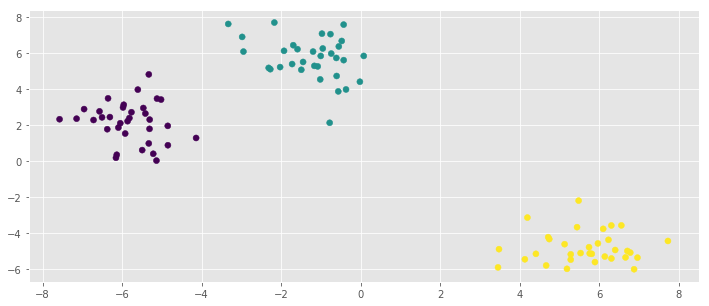

In [88]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

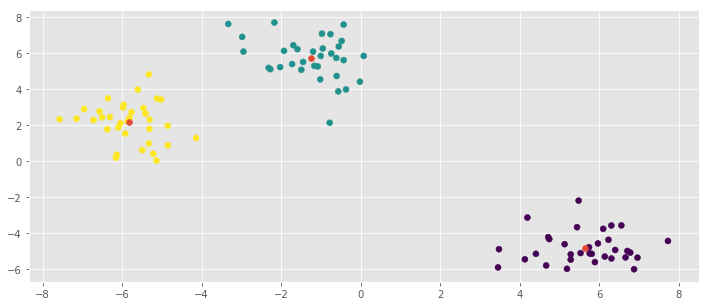

In [89]:
## Работоспособность MyKmeans
clf = MyKmeans(k=3)
clf.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=clf.predict(X))
plt.scatter(clf.centroids[:, 0], clf.centroids[:, 1])

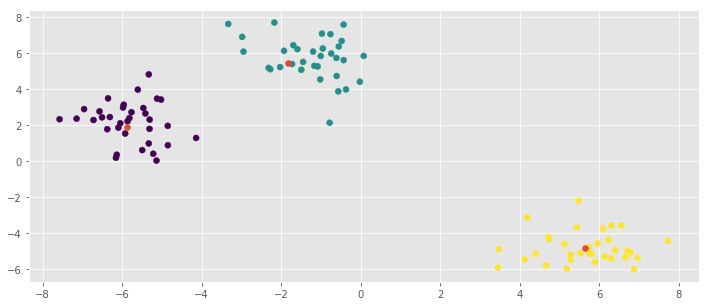

In [90]:
## Работоспособность MyKmeans++
clf = MyKmeans(k=3, init='k-means')
clf.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=clf.predict(X))
plt.scatter(clf.centroids[:, 0], clf.centroids[:, 1])

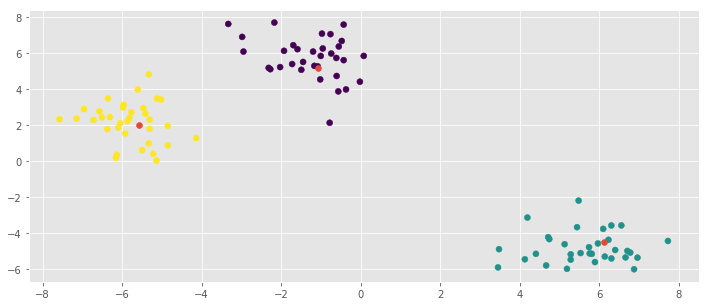

In [91]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
clf = MiniBatchMyKMeans(k=3, batch_size=10)
clf.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=clf.predict(X))
plt.scatter(clf.centroids[:, 0], clf.centroids[:, 1])

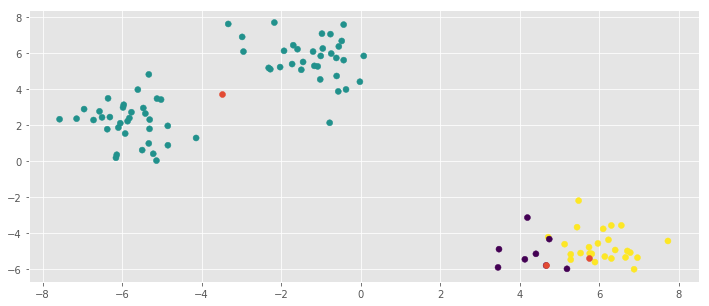

In [92]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
clf = MiniBatchMyKMeans(k=3, init='k-means', batch_size=10)
clf.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=clf.predict(X))
plt.scatter(clf.centroids[:, 0], clf.centroids[:, 1])

In [93]:
## Время выполнения алгоритма Kmeans из sklearn
clf = KMeans(n_clusters=3, max_iter=1000, tol=0)
%time clf.fit(X)

Wall time: 936 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0, verbose=0)

In [94]:
## Время выполнения алгоритма MyKmeans
my_clf = MyKmeans(k=3, init='random')
%time my_clf.fit(X)

Wall time: 998 µs


In [95]:
## Время выполнения алгоритма MyKmeans++
my_clf = MyKmeans(k=3, init='k-means')
%time my_clf.fit(X)

Wall time: 997 µs


In [96]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
my_clf = MiniBatchMyKMeans(k=3, init='random')
%time my_clf.fit(X)

Wall time: 997 µs


In [97]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
my_clf = MiniBatchMyKMeans(k=3, init='k-means')
%time my_clf.fit(X)

Wall time: 2 ms


In [98]:
# Задание 4

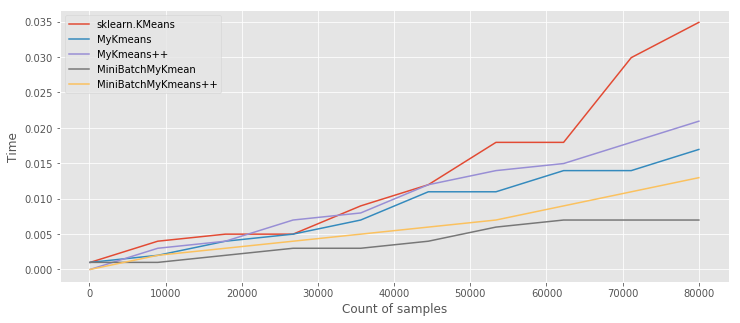

In [120]:
clf = KMeans(n_clusters=3, init='random', max_iter=1000, n_init=1)
clf2 = MyKmeans(k=3, init='random', max_iter=1000)
clf3 = MyKmeans(k=3, init='k-means', max_iter=1000)
clf4 = MiniBatchMyKMeans(k=3, batch_size=10)
clf5 = MiniBatchMyKMeans(k=3, init='k-means', batch_size=10)
samples = np.linspace(100, 80000, 10, dtype=int)
info = np.empty((5, samples.shape[0]))
names = ['sklearn.KMeans', 'MyKmeans', 'MyKmeans++', 'MiniBatchMyKmean', 'MiniBatchMyKmeans++']

for j, size in enumerate(samples):
    X, y = make_blobs(n_samples=size, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

    for i, model in enumerate([clf, clf2, clf3, clf4, clf5]):
        t0 = time()
        model.fit(X)
        info[i][j] = time() - t0

for i in range(5):
    plt.plot(samples, info[i], label=names[i])

plt.xlabel('Count of samples')
plt.ylabel('Time')
plt.legend()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [125]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [131]:
df = df_sns.drop(['gradyear', 'gender', 'age', 'friends'], axis='columns')
df = (df - df.mean()) / df.std()
keys = df.columns

In [134]:
def getInfo(clf, N):
    unique, counts = np.unique(clf.predict(df), return_counts=True)
    
    for i in range(9):
        print(f'{i + 1} кластер')
        print(f'{counts[i]} students')
        indices = np.argpartition(-clf.centroids[i], N)[:N]
        print(list(keys[indices]))
        print()

In [143]:
## MyKMeans
clf = MyKmeans(k=9)
clf.fit(df.values)
getInfo(clf, 6)

1 кластер
2085 students
['mall', 'clothes', 'shopping', 'cute', 'church', 'basketball']

2 кластер
1126 students
['jesus', 'death', 'soccer', 'sports', 'god', 'die']

3 кластер
504 students
['sex', 'drugs', 'drunk', 'hair', 'kissed', 'die']

4 кластер
1699 students
['swimming', 'hot', 'shopping', 'dress', 'football', 'god']

5 кластер
1066 students
['basketball', 'softball', 'sports', 'football', 'volleyball', 'baseball']

6 кластер
15721 students
['baseball', 'blonde', 'bible', 'tennis', 'cute', 'sexy']

7 кластер
6513 students
['marching', 'band', 'music', 'rock', 'god', 'dance']

8 кластер
622 students
['hair', 'kissed', 'music', 'die', 'rock', 'drugs']

9 кластер
664 students
['hollister', 'hair', 'shopping', 'cute', 'abercrombie', 'clothes']



In [147]:
## MyKMeans++
clf = MyKmeans(k=9, init='k-means')
clf.fit(df.values)
getInfo(clf, 6)

1 кластер
22630 students
['tennis', 'marching', 'blonde', 'band', 'soccer', 'sexy']

2 кластер
464 students
['basketball', 'church', 'drunk', 'bible', 'god', 'jesus']

3 кластер
120 students
['jesus', 'bible', 'god', 'death', 'die', 'church']

4 кластер
3431 students
['hair', 'sports', 'drugs', 'softball', 'kissed', 'music']

5 кластер
133 students
['hollister', 'shopping', 'cute', 'abercrombie', 'clothes', 'hair']

6 кластер
1119 students
['cheerleading', 'church', 'shopping', 'baseball', 'cute', 'football']

7 кластер
1079 students
['clothes', 'shopping', 'mall', 'hollister', 'abercrombie', 'football']

8 кластер
322 students
['hair', 'kissed', 'sex', 'rock', 'drugs', 'die']

9 кластер
702 students
['swimming', 'shopping', 'clothes', 'basketball', 'volleyball', 'mall']



In [138]:
## MyKMeans с MiniBatchMyKMeans
clf = MiniBatchMyKMeans(k=9, batch_size=100)
clf.fit(df.values)
getInfo(clf, 6)

1 кластер
1449 students
['death', 'jesus', 'god', 'kissed', 'clothes', 'hair']

2 кластер
419 students
['tennis', 'marching', 'blonde', 'bible', 'music', 'band']

3 кластер
11064 students
['volleyball', 'drugs', 'die', 'softball', 'church', 'sex']

4 кластер
177 students
['drugs', 'music', 'clothes', 'kissed', 'swimming', 'mall']

5 кластер
1323 students
['rock', 'music', 'dance', 'dress', 'cute', 'clothes']

6 кластер
936 students
['hot', 'sexy', 'shopping', 'hair', 'music', 'band']

7 кластер
13699 students
['band', 'bible', 'blonde', 'marching', 'tennis', 'sex']

8 кластер
381 students
['cheerleading', 'tennis', 'mall', 'drunk', 'abercrombie', 'basketball']

9 кластер
552 students
['hair', 'sex', 'die', 'clothes', 'kissed', 'volleyball']



In [139]:
## MyKMeans++ с MiniBatchMyKMeans
clf = MiniBatchMyKMeans(k=9, init='k-means', batch_size=100)
clf.fit(df.values)
getInfo(clf, 6)

1 кластер
7472 students
['marching', 'band', 'sports', 'hair', 'die', 'music']

2 кластер
123 students
['basketball', 'football', 'shopping', 'soccer', 'sports', 'music']

3 кластер
568 students
['hair', 'jesus', 'shopping', 'mall', 'cheerleading', 'blonde']

4 кластер
534 students
['baseball', 'cheerleading', 'abercrombie', 'hollister', 'clothes', 'rock']

5 кластер
2472 students
['football', 'volleyball', 'soccer', 'swimming', 'basketball', 'hot']

6 кластер
15598 students
['bible', 'dress', 'blonde', 'death', 'cheerleading', 'swimming']

7 кластер
1 students
['blonde', 'sex', 'drunk', 'death', 'hair', 'die']

8 кластер
62 students
['tennis', 'sexy', 'rock', 'football', 'baseball', 'music']

9 кластер
3170 students
['hot', 'softball', 'kissed', 'shopping', 'basketball', 'bible']



In [151]:
## Вывод
#Прогоняя один алгоритм несколько раз мы можем получат различные результаты и выбрать среди них определеныйю
#Глобально мы можем разделить алгоритмы на две группы: С батчами и без. У нас есть разница в скорости и в точности.
# KMeans++ - более правильный способ раскидывать начальные точки, что понижает шанс создания странных кластеров. 